# Time Series(ARIMA) forecast with Python

We are going to cover:
1. What is Time Series and ARIMA
2. Loading and handling time series in Python
3. Checking for stationarity of a Time Series
4. Transforming Time Series to stationary
5. Forecasting a time Series

## 1. What is Time Series and ARIMA

A time series is a sequence of numerical data points in successive order. It can be taken as any variable that changes over time. Example, price of a security at close on the last day of every month over the course of five years.

Time series are time dependent, observations are dependent on historical time values.
Have a trends and in majority of the cases a seasnality trend (variation specfic to a particular time frame). For example, sales in snowbards increases during the winter months and decreases during the summer months

ARIMA stands for AR = Auto Regressive , I = Integrated , MA = Moving Averages It is a technique of used for time series forcasting.
<br>
Auto Regressive: Lags of variable itself.
<br>
Integreated: Differencing steps required to make stationary
<br>
Moving Average: Lags of previous information shocks
<br>
ARIMA(p,d,q) model has three parameters.
<br>
(p): Number of AR terms
<br>
(q): Number of MA terms/The size of the moving average window, also called the order of moving average
<br>
(d): Number of differences
<br>
Prequisite
<br>
Requires the data to be stationary - stationarity is when the mean and variance are constant over time
<br>
Steps
<br>
1. Visualize the time series data
2. Check for stationarity, if false: make your data stationary
3. Plot the correlation and auto corelation
4. Construct the ARIMA model
5. Use the model to make predictions

## 2. Loading and handling time series in Python

Python has three libraries that can be use to deal with time series data.  Pandas and Statsmodels to to deal with loading and handling the data. Matplotlib to for visualizations.

In [71]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

Load the dataset and explore intial rows and data types of the columns

In [2]:
df = pd.read_csv('/Users/Somev/Documents/programming/python/data_/monthly-milk-production-pounds-p.csv')
df.head()


,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


The data contains poor column title. Lets rename the column to better represent the data. 

In [3]:
df.columns =['Month','Milk in Pounds per Cow']

In [4]:
print(df)
print('\n Data Types:')
print(df.dtypes)

                                                 Month  Milk in Pounds per Cow
0                                              1962-01                   589.0
1                                              1962-02                   561.0
2                                              1962-03                   640.0
3                                              1962-04                   656.0
4                                              1962-05                   727.0
5                                              1962-06                   697.0
6                                              1962-07                   640.0
7                                              1962-08                   599.0
8                                              1962-09                   568.0
9                                              1962-10                   577.0
10                                             1962-11                   553.0
11                                             1962-

What do we see?
<br>
-The data contains monthly milk production per cow from 1962 to 1975
<br>
-The month column is not the index and is not in proper datetime data type format. 
<br>
-We can see that row 168 is a null.

For large datasets it is impossible to spot all null values visually. Lets check for nulls with Pandas isnull()

In [5]:
df[pd.isnull(df['Month'])]

,Month,Milk in Pounds per Cow


In [6]:
df[pd.isnull(df['Milk in Pounds per Cow'])]

,Month,Milk in Pounds per Cow
168,Monthly milk production: pounds per cow. Jan 6...,NaN


Dealing with the null vlaue

In [7]:
df.drop(168,axis=0,inplace=True)

In [8]:
df.tail()

,Month,Milk in Pounds per Cow
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


Adressing the month column index and  datatime data type issue.

In [9]:
df['Month']= pd.to_datetime(df['Month'])

In [10]:
df.set_index('Month', inplace=True)


In [11]:
df.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)

### Step 1.Visualize the series data

Statistics

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


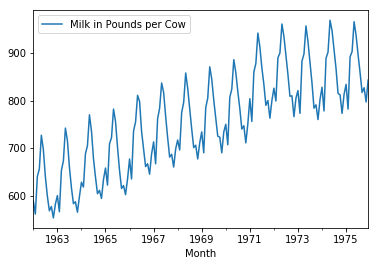

In [13]:
df.plot()

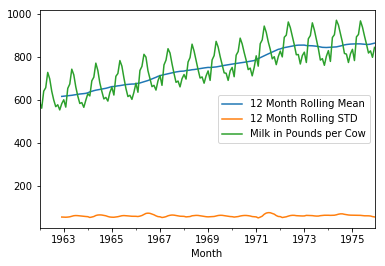

In [14]:
time_series = df['Milk in Pounds per Cow']
time_series.rolling(12).mean().plot(label='12 Month Rolling Mean')
time_series.rolling(12).std().plot(label='12 Month Rolling STD')
time_series.plot()
plt.legend()

We can see an increasing trend in cows milk production.
<br>
From this graph, there appears to be seasonlity. Milk prodouction peaks during mid year.


Confirming Error, Trend, and Seasonlity (ETS) with ETS decomposition

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

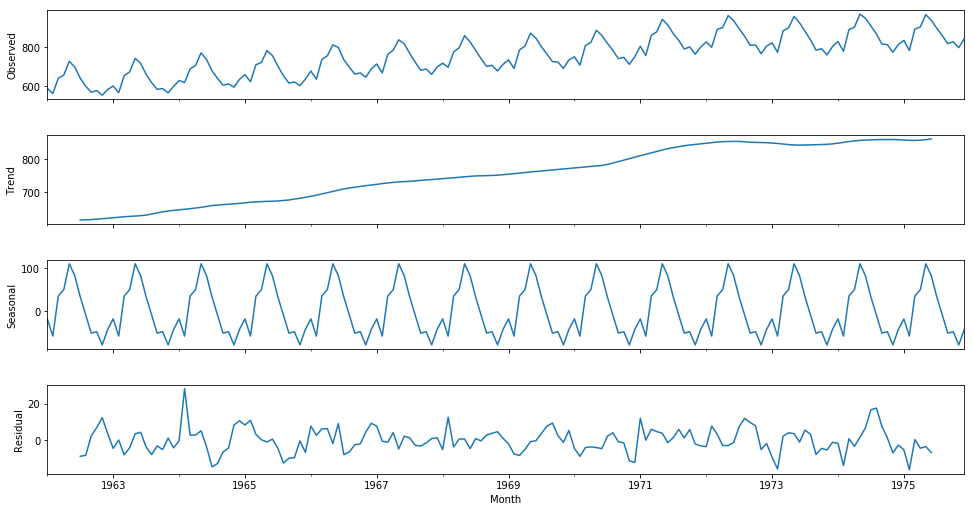

In [16]:
decomp = seasonal_decompose(time_series,freq=12)
fig = decomp.plot()
fig.set_size_inches(15,8)

We can confirm our data set has an increasing trend and a seasonal trend

### Checking for stationarity

Check for stationarity with the Dickey Fuller Test.
<br>
Run a hypothesis test
<br>
<b>null hypothesis </b> = the time series is non stationary
<br>
<b>alternative hypothesis </b> = the time series is stationary

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adf_check(time_series):
    result = adfuller(time_series)
    print(' Augmented Dicky-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value','# of lags','Num of Observations used']
    
    for value, label in zip(result,labels):
        print(label+ ' : '+str(value))
    
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('reject null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('weak evidence against null hypothesis')
        print('Fail to rejct null hypothesis')
        print('Data has a unit root, it is non -stationary')

In [19]:
adf_check(df['Milk in Pounds per Cow'])

 Augmented Dicky-Fuller Test
ADF Test Statistic : -1.30381158742
p-value : 0.627426708603
# of lags : 13
Num of Observations used : 154
weak evidence against null hypothesis
Fail to rejct null hypothesis
Data has a unit root, it is non -stationary


With a p value > 0.05, there is strong evidence supporting the null hypothesis. Thus fail, to reject the null hypothesis. 

Differencing to make our data stationary

In [20]:
df['First Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(1)

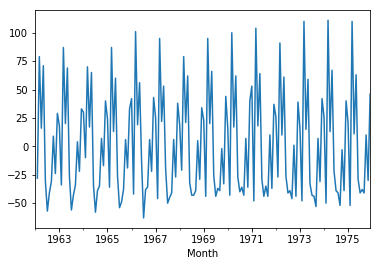

In [21]:
df['First Difference'].plot()

In [22]:
adf_check(df['First Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic : -3.05499555865
p-value : 0.0300680040018
# of lags : 14
Num of Observations used : 152
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


With a p value < 0.05, there is strong evidence against the null hypothesis. Thus, we reject the null hypothesis. The data set is now stationary.



If the data set is not stationary after the first difference, one can further difference until stationary and desired p value. Just remember that you give up a row of data for ever level of difference. 

Example of differencing further

In [23]:
df['Milk Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)

In [24]:
adf_check(df['Milk Second Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic : -14.3278736456
p-value : 1.11269893321e-26
# of lags : 11
Num of Observations used : 154
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


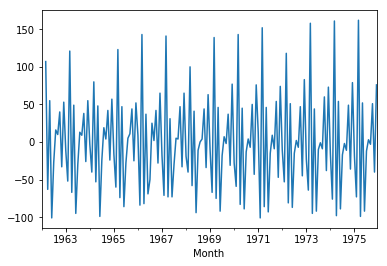

In [25]:
df['Milk Second Difference'].plot()

Since this data set contains a seasonal trend we have to also make it stationary

In [26]:
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)

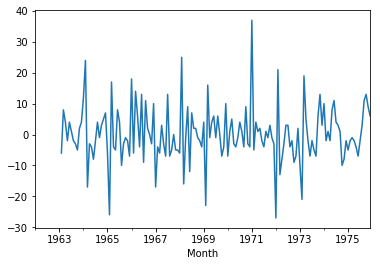

In [27]:
df['Seasonal First Difference'].plot()

In [28]:
adf_check(df['Seasonal First Difference'].dropna())

 Augmented Dicky-Fuller Test
ADF Test Statistic : -5.03800227492
p-value : 1.86542343188e-05
# of lags : 11
Num of Observations used : 143
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


With a p value < 0.05, there is strong evidence against the null hypothesis. Thus, we reject the null hypothesis. The data set is now stationary.



### Step 3 Plot the correlation and auto correlation

Autocorrelation Function is a measure of correlation between the time series with a lagged version of itself. 
<br>
Gives us the number of terms of MA
<br>
Partial Autocorrelation Function: this measures the correlation between the time series with a lagged version of itself but after elimnating the variations already explained by the intervening comparisons.
<br>
Gives us the number of terms of AR

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

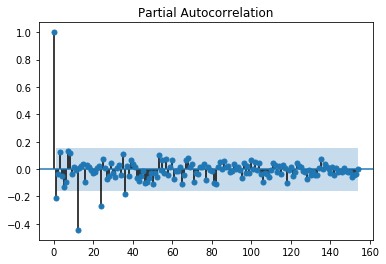

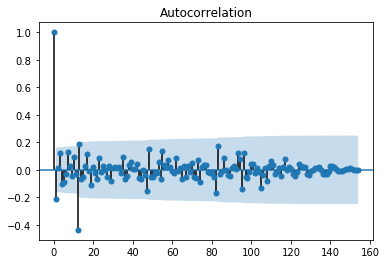

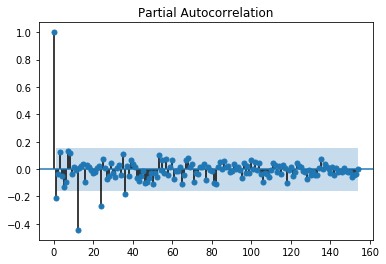

In [30]:
plot_acf(df['Seasonal First Difference'].dropna())
plot_pacf(df['Seasonal First Difference'].dropna())

If the autocrrelation plot shows positive autocorrelation at the first lag lag(-1) then it suggests you use AR term in relation to the lag
<br>
If the autocrrelation plot shows negative autocorrelation at the first lag lag(-1) then it suggests you use MA term in relation to the lag
<br>
PACF will indicate AR terms and ACF will show MA terms
<br>
p – The lag value where the PACF chart crosses the upper confidence interval for the first time. In this case p is equal to 1
<br>
q – The lag value where the ACF chart crosses the upper confidence interval for the first time.
In this case q is equal to 1

## Step 4. Construct ARIMA model

In [31]:
from statsmodels.tsa.arima_model import ARIMA

Since our data set contains a season trend we use the seasonal ARIMA model
<br>
Notice how the non seasonal order(p,d,q) only contains d. Seasonal p = 1, d= 1 , q= 1, and 12 for the months in a year. 

In [32]:
model =sm.tsa.statespace.SARIMAX(df['Milk in Pounds per Cow'],order=(0,1,0),seasonal_order=(1,1,1,12))

In [33]:
results = model.fit()

In [34]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Tue, 10 Oct 2017   AIC                           1074.131
Time:                                    16:16:15   BIC                           1083.503
Sample:                                01-01-1962   HQIC                          1077.934
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

Validating the model

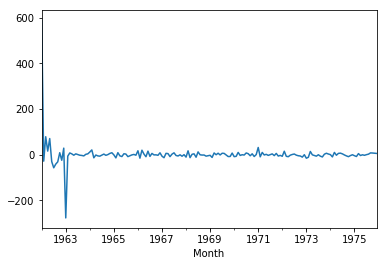

In [35]:
results.resid.plot()

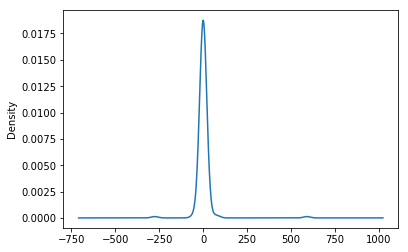

In [36]:
results.resid.plot(kind='kde')

Residuals are normaly distributed and have a constant spread throughout the range.

## Step 5 Forecasting

Now we are going to test our model by taking historical values and using them to predict values that we already know.

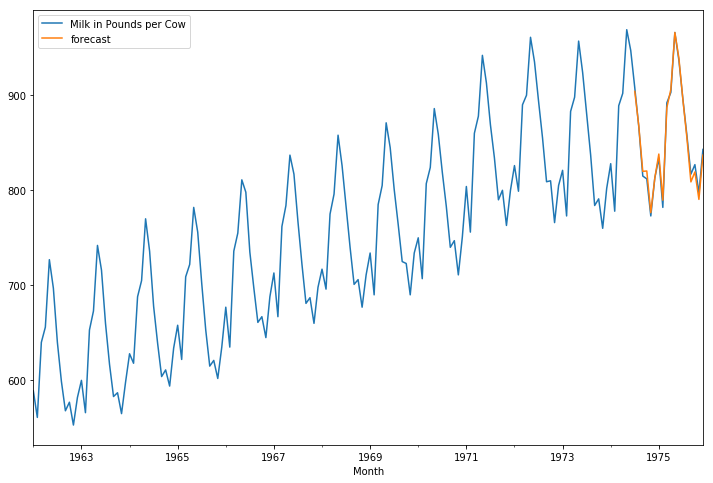

In [37]:
df['forecast'] = results.predict(start=150, end=168)
df[['Milk in Pounds per Cow', 'forecast']].plot(figsize=(12,8))

The orange line is our predicted value which is very close to the actual value(blue line). The model looks very accurate.

Lets add 24 more months to forecast.

In [52]:
from pandas.tseries.offsets import DateOffset

In [62]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]

In [63]:
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [64]:
future_df = pd.DataFrame(index=future_dates, columns=df.columns)

In [65]:
future_df

,Milk in Pounds per Cow,First Difference,Milk Second Difference,Seasonal First Difference,forecast
1976-01-01,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN
1976-06-01,NaN,NaN,NaN,NaN,NaN
1976-07-01,NaN,NaN,NaN,NaN,NaN
1976-08-01,NaN,NaN,NaN,NaN,NaN
1976-09-01,NaN,NaN,NaN,NaN,NaN
1976-10-01,NaN,NaN,NaN,NaN,NaN


In [66]:
final_df = pd.concat([df,future_df])

In [67]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Milk Second Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN


In [68]:
final_df['forecast'] = results.predict(start=168, end=192)

In [69]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Milk Second Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,951.525751
1977-08-01,NaN,NaN,NaN,NaN,911.918840
1977-09-01,NaN,NaN,NaN,NaN,865.881041
1977-10-01,NaN,NaN,NaN,NaN,871.027162
1977-11-01,NaN,NaN,NaN,NaN,836.962873


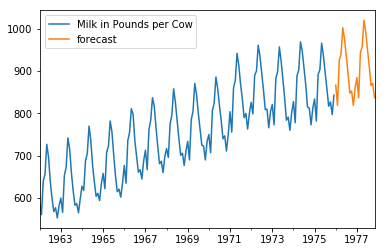

In [70]:
final_df[['Milk in Pounds per Cow','forecast']].plot()
